# Label scores analyses

This notebook performs the following analysis steps:
* aggregating data across seeds, by phenomenon, by model, by label type
* transforming raw metrics into probabilities by item by metric
    * this requires working by-phenomenon, because there are different numbers of options in the different phenomena
* combining this data into one cleaned data file with binarized options (probabilities of target vs rest)
    * long formatting of options and of metrics
* averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
* plotting results by metric, by phenomenon, by model, by label type

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

In [150]:
# read data and combine
model_names = ["llama2", "flan-t5-xl", "gpt-3.5-turbo-instruct", "text-davinci-002"]
label_types = ["label_alpha", "label_numeric"]

raw_df = pd.DataFrame()
for model in model_names:
    print("Model ", model)
    for label_type in label_types:
        results_path = glob.glob(f"../results/log_probs/{model}/*/label_scores/{label_type}/*.csv")
        print("Number of files to concat ", len(results_path))
        for p in results_path:
#             print("Reading file ", p)
            d = pd.read_csv(p)
            d["metric"] = "label_score"
            d["label_type"] = label_type
            
            raw_df = pd.concat([raw_df, d])    

Model  llama2
Number of files to concat  35
Number of files to concat  35
Model  flan-t5-xl
Number of files to concat  35
Number of files to concat  35
Model  gpt-3.5-turbo-instruct
Number of files to concat  35
Number of files to concat  31
Model  text-davinci-002
Number of files to concat  35
Number of files to concat  35


In [151]:
print(len(raw_df))
raw_df.head()

25740


,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,token_probs,sentence_cond_probs,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type
0,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,A,target,...,[0.0021805406873923253],0.003313,0.003313,0.002181,1.519248,-5.709967,-5.709967,0.931755,label_score,label_alpha
1,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,B,incorrect_straightforward,...,[0.0018741641342209612],0.002067,0.002067,0.001874,1.103044,-6.181519,-6.181519,0.984382,label_score,label_alpha
2,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,C,associative_nonsequitur,...,[0.003587298613933627],0.001646,0.001646,0.003587,0.458951,-6.409168,-6.409168,1.138324,label_score,label_alpha
3,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,D,funny_nonsequitur,...,[0.002218916267492813],0.001804,0.001804,0.002219,0.812816,-6.317986,-6.317986,1.033916,label_score,label_alpha
4,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,E,neutral_nonsequitur,...,[0.0014657024465339016],0.000984,0.000984,0.001466,0.671308,-6.923948,-6.923948,1.061073,label_score,label_alpha


In [152]:
raw_df.columns

Index(['model_name', 'temperature', 'seed', 'item_id', 'phenomenon', 'prompt',
       'prior_prompt', 'question', 'options', 'option_names',
       'shuffled_options', 'shuffled_option_names', 'option_numbering',
       'token_cond_log_probs', 'token_cond_probs', 'prior_token_log_probs',
       'null_prior_token_log_probs', 'token_probs', 'sentence_cond_probs',
       'mean_sentence_cond_probs', 'prior_sentence_probs', 'sentence_mi',
       'sentence_surprisal', 'mean_sentence_surprisal',
       'sentence_mi_surprisal', 'metric', 'label_type'],
      dtype='object')

In [153]:
coherence_df = raw_df[raw_df['phenomenon'] == 'coherence']
deceits_df = raw_df[raw_df['phenomenon'] == 'deceits']
humours_df = raw_df[raw_df['phenomenon'] == 'humour']
indirect_df = raw_df[raw_df['phenomenon'] == 'indirect_speech']
irony_df = raw_df[raw_df['phenomenon'] == 'irony']
maxims_df = raw_df[raw_df['phenomenon'] == 'maxims']
metaphor_df = raw_df[raw_df['phenomenon'] == 'metaphor']

For the sanity check, here are the expected numbers of rows in each phenomenon, computed as: models * seed * items * options

* coherence: 4 * 5 * 40 * 2 = 1200 => 2400
* deceits: 4 * 5 * 20 * 4 = 1200 => 2400
* humour: 4 * 5 * 25 * 5 = 1875 => 3750
* indirect: 4 * 5 * 20 * 4 = 1200 => 2400
* irony: 4 * 5 * 25 * 4 = 1500 => 3000
* maxims: 4 * 5 * 19 * 4 = 1140 => 2280
* metaphor: 4 * 5 * 20 * 5 = 1500 => 3000

And for each x 2 for the numeric and alpha labels.

In [154]:
# somehow irony has 100 duplicate entries -- exclude
irony_df = irony_df.drop_duplicates()
len(irony_df)

4000

In [155]:
def identify_max(r, option_names):
    """
    Helper for retrieving name of option
    for which score was maximal for row r.
    """
    option_vals = [r[o] for o in option_names]
    # identiry max, otherwise random tie breaking
    if option_vals.count(max(option_vals)) > 1:
        # choose randomly amongst the max prob options
        max_options = [option_names[i] for i, j in enumerate(option_vals) if j == max(option_vals)]
        chosen_option = random.choice(max_options)
    else:
        chosen_option = option_names[
            option_vals.index(max(option_vals))
        ]
    return chosen_option

def transform_to_wide_and_softmax(df, option_names = ['target', 'competitor']):
    """
    Helper function for pivoting dataframes 
    to wide format and transforming metric results into 
    probabilities.
    Metric columns are collected into long format first for this.
    """
    # pivot all the metrics into one column
    df_subset = df[["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal", "metric", "label_type"]]
    df_subset = df_subset.rename(columns={
        "sentence_cond_probs": "value_sentence_cond_probs", 
        "mean_sentence_cond_probs": "value_mean_sentence_cond_probs", 
        "sentence_mi": "value_sentence_mi", 
        "sentence_surprisal": "value_sentence_surprisal", 
        "mean_sentence_surprisal": "value_mean_sentence_surprisal", 
        "sentence_mi_surprisal": "value_sentence_mi_surprisal"
    })
#     print(df_subset.head(5))
    df_long = pd.wide_to_long(
        df_subset, 
        stubnames="value_", 
        i=["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "metric", "label_type"], 
        j="metric_formula",
        suffix='\\w+', 
    )
    df_long = df_long.reset_index()
    # fill NAs with 0
    df_long['value_'] = df_long["value_"].fillna(0)
    
    # spread different response options so that softmax can be applied
    df_wide = df_long.pivot_table(
        index=["model_name", "seed", "item_id", "phenomenon","metric", "label_type", "metric_formula"],
        columns="shuffled_option_names",
        values="value_"
    )
    df_wide = df_wide.reset_index()
    df_wide_raw = df_wide.copy()
    
    # softmax options over response option types
    df_wide["denominator"] = df_wide[option_names].sum(axis=1)
    for o in option_names:
        df_wide[o] = df_wide[o]/df_wide["denominator"]
    # additionally, pull option for which the value was maximal
    df_wide_raw["chosen_option"] = df_wide_raw.apply(
        lambda r: identify_max(r, option_names), 
        axis=1
    )
    
    return df_wide, df_wide_raw

In [156]:
def is_any_na(r, metric_formula=["sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal"]):
    return any([r[o] for o in metric_formula])

def check_na(df):
    """
    Helper for checking for NaNs.
    """
    df_subset = df[["sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal"]].isna()
    df_subset["is_any_na"] = df_subset.apply(lambda r: is_any_na(r), axis=1)
    
    return df_subset[df_subset['is_any_na'] == True]
    

In [340]:
# no NAs
check_na(metaphor_df)

,sentence_cond_probs,mean_sentence_cond_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,is_any_na


In [157]:
# apply the helper to all phenomena (fist df is processed (i.e., softmaxed), second is raw)
# the second dataframe is the one that includes information about which option had the highest score ("chosen_option")
# therefore, this is used further
coherence_processed, coherence_processed_ = transform_to_wide_and_softmax(coherence_df)
deceits_processed, deceits_processed_ = transform_to_wide_and_softmax(deceits_df, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"])
humours_processed, humours_processed_ = transform_to_wide_and_softmax(humours_df, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"])
indirect_processed, indirect_processed_ = transform_to_wide_and_softmax(indirect_df, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"])
irony_processed, irony_processed_ = transform_to_wide_and_softmax(irony_df, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"])
maxims_processed, maxims_processed_ = transform_to_wide_and_softmax(maxims_df, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"])
metaphor_processed, metaphor_processed_ = transform_to_wide_and_softmax(metaphor_df, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"])

In [159]:
# binarize the processed data into target vs non-target probability
# or into numerical representation of target vs non-target
def binarize_df(df, is_argmax=False):
    if is_argmax:
        df["correct"] = df["chosen_option"].apply(lambda s: int(s == "target"))
        df_subset = df[['metric_formula', "model_name", "seed", "item_id", "phenomenon", "metric", "label_type", "chosen_option", "correct"]]
    else: 
        df["distractor_prob"] = 1 - df["target"] 
        df_subset = df[['metric_formula', "model_name", "seed", "item_id", "phenomenon", "metric", "label_type", "target", "distractor_prob"]]
    
    return df_subset

In [160]:
humours_processed.head()

shuffled_option_names,model_name,seed,item_id,phenomenon,metric,label_type,metric_formula,associative_nonsequitur,funny_nonsequitur,incorrect_straightforward,neutral_nonsequitur,target,denominator
0,google/flan-t5-xl,0,1,humour,label_score,label_alpha,mean_sentence_cond_probs,0.180207,0.119104,0.188801,0.308976,0.202912,0.299345
1,google/flan-t5-xl,0,1,humour,label_score,label_alpha,mean_sentence_surprisal,0.204058,0.232999,0.200802,0.166378,0.195764,-14.308727
2,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_cond_probs,0.180207,0.119104,0.188801,0.308976,0.202912,0.299345
3,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_mi,0.129817,0.298572,0.154060,0.173545,0.244006,5.146874
4,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_mi_surprisal,0.227118,0.173405,0.212948,0.205500,0.181028,5.108504


In [161]:
# apply binarization
coherence_binary = binarize_df(coherence_processed_, is_argmax=True)
deceits_binary = binarize_df(deceits_processed_, is_argmax=True)
humours_binary = binarize_df(humours_processed_, is_argmax=True)
indirect_binary = binarize_df(indirect_processed_, is_argmax=True)
irony_binary = binarize_df(irony_processed_, is_argmax=True)
maxims_binary = binarize_df(maxims_processed_, is_argmax=True)
metaphor_binary = binarize_df(metaphor_processed_, is_argmax=True)

In [162]:
# combine all into one cleaned file
label_scores = pd.concat([coherence_binary,deceits_binary,humours_binary,indirect_binary,irony_binary, maxims_binary,metaphor_binary])

In [164]:
#label_scores.to_csv("../results/log_probs/label_scores_all_cleaned_argmax_binarized.csv", index=False)
label_scores.head()
len(label_scores)

40560

In [165]:
# analyse the data
# averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
# just for eyeballing
scores_binary_summary = label_scores.groupby(["model_name", "metric_formula", "phenomenon", "label_type"]).mean(["correct"]).reset_index()
scores_binary_summary 

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,correct
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.535000
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.530000
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.200000
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.210000
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.136000
...,...,...,...,...,...,...,...
331,text-davinci-002,sentence_surprisal,irony,label_numeric,2.0,13.0,0.632000
332,text-davinci-002,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.694737
333,text-davinci-002,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.684211
334,text-davinci-002,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.750000


In [166]:
# max accuracy by model by phenomenon
scores_binary_summary.groupby(["model_name", "phenomenon"]).max("correct")

shuffled_option_names                     seed  item_id   correct
model_name               phenomenon                              
google/flan-t5-xl        coherence         2.0     20.5  0.550000
                         deceits           2.0     10.5  0.310000
                         humour            2.0     13.0  0.304000
                         indirect_speech   2.0     10.5  0.330000
                         irony             2.0     13.0  0.368000
                         maxims            2.0     10.0  0.336842
                         metaphor          2.0     10.5  0.230000
gpt-3.5-turbo-instruct   coherence         2.0     20.5  0.640000
                         deceits           2.0     10.5  0.610000
                         humour            2.0     13.0  0.392000
                         indirect_speech   2.0     10.5  0.650000
                         irony             2.0     13.0  0.592000
                         maxims            2.0     10.0  0.421053
                         metaphor          2.0     10.5  0.740000
meta-llama/Llama-2-7b-hf coherence         2.0     20.5  0.555000
                         deceits           2.0     10.5  0.340000
                         humour            2.0     13.0  0.272000
                         indirect_speech   2.0     10.5  0.300000
                         irony             2.0     13.0  0.344000
                         maxims            2.0     10.0  0.294737
                         metaphor          2.0     10.5  0.280000
text-davinci-002         coherence         2.0     20.5  0.645000
                         deceits           2.0     10.5  0.910000
                         humour            2.0     13.0  0.480000
                         indirect_speech   2.0     10.5  0.890000
                         irony             2.0     13.0  0.696000
                         maxims            2.0     10.0  0.694737
                         metaphor          2.0     10.5  0.770000

In [167]:
# average accuracy by model
scores_binary_summary.groupby(["model_name"]).mean("target")

shuffled_option_names,seed,item_id,correct
model_name,,,
google/flan-t5-xl,2.0,12.571429,0.261489
gpt-3.5-turbo-instruct,2.0,12.571429,0.485507
meta-llama/Llama-2-7b-hf,2.0,12.571429,0.261571
text-davinci-002,2.0,12.571429,0.593146


In [168]:
# set CSP color palette
csp_colors = ["#7581B3", "#C65353", "#E2BA78", "#5C7457", "#99C2C2", "#575463",
             "#B0B7D4", "#66A3A3", "#DB9494", "#D49735", "#9BB096", "#D4D3D9",
             "#414C76", "#993333"]
csp_custom_palette = sns.set_palette(sns.color_palette(csp_colors))

In [169]:
# read human by-response-category data from Hu et al
human_category_summary = pd.read_csv('../data/human_results/human_response_proportions.csv')
human_category_summary

,phenomenon,item_id,model,answer_label_complex,prob,seed
0,Humor,1,Human,AssociativeNonSequitur,0.021390,NaN
1,Humor,1,Human,CorrectNonLiteral,0.925134,NaN
2,Humor,1,Human,FunnyNonSequitur,0.013369,NaN
3,Humor,1,Human,IncorrectStraightforward,0.026738,NaN
4,Humor,1,Human,NeutralNonSequitur,0.013369,NaN
...,...,...,...,...,...,...
556,Metaphor,20,Human,CorrectNonLiteral,0.983957,NaN
557,Metaphor,20,Human,IncorrectLiteral,0.008021,NaN
558,Metaphor,20,Human,IncorrectNonLiteral,0.002674,NaN
559,Metaphor,20,Human,IncorrectNonSequitur,0.005348,NaN


In [170]:
# process
human_category_summary_avg = human_category_summary.groupby(["phenomenon", "answer_label_complex"]).mean(["prob"]).reset_index()
# write out for manual processing
# human_category_summary_avg.to_csv('../data/human_results/human_response_proportions_annotated.csv', index=False)
human_category_summary_avg = pd.read_csv('../data/human_results/human_response_proportions_annotated.csv')

In [171]:
# read human results for the "correlation plot"
df_human_coherence = pd.read_csv("../data/human_results/Human_CoherenceInference.csv") 
df_human_coherence["phenomenon"] = "coherence"
df_human_deceits = pd.read_csv("../data/human_results/Human_Deceits.csv") 
df_human_deceits["phenomenon"] = "deceits"
df_human_humour = pd.read_csv("../data/human_results/Human_Humour.csv") 
df_human_humour["phenomenon"] = "humour"
df_human_indirect = pd.read_csv("../data/human_results/Human_IndirectSpeech.csv") 
df_human_indirect["phenomenon"] = "indirect_speech"
df_human_irony = pd.read_csv("../data/human_results/Human_Irony.csv") 
df_human_irony["phenomenon"] = "irony"
df_human_metaphor = pd.read_csv("../data/human_results/Human_Metaphor.csv") 
df_human_metaphor["phenomenon"] = "metaphor"
df_human_maxims = pd.read_csv("../data/human_results/Human_Maxims.csv") 
df_human_maxims["phenomenon"] = "maxims"

In [172]:
df_human_all = pd.concat([df_human_coherence, df_human_deceits, df_human_humour, df_human_indirect, df_human_irony, df_human_metaphor, df_human_maxims])

In [173]:
df_human_summary = df_human_all.groupby(["phenomenon"]).mean("Correct")


In [174]:
df_human_summary = df_human_summary.reset_index()
df_human_summary

,phenomenon,Unnamed: 0,pKey,itemNum,Correct
0,coherence,7480.5,274.371658,20.5,0.856684
1,deceits,3740.5,274.371658,10.5,0.841979
2,humour,4675.5,274.371658,13.0,0.846845
3,indirect_speech,3740.5,274.371658,10.5,0.885963
4,irony,4675.5,274.371658,13.0,0.919465
5,maxims,3740.5,274.371658,10.5,0.795856
6,metaphor,3740.5,274.371658,10.5,0.896791


In [175]:
# add human proportion to model summary
scores_binary_summary_wHuman = scores_binary_summary.copy()

for i, r in scores_binary_summary_wHuman.iterrows():
    phenomenon = r['phenomenon']
    val = float(df_human_summary[df_human_summary["phenomenon"] == phenomenon]['Correct'])
    scores_binary_summary_wHuman.loc[i, 'human'] = val

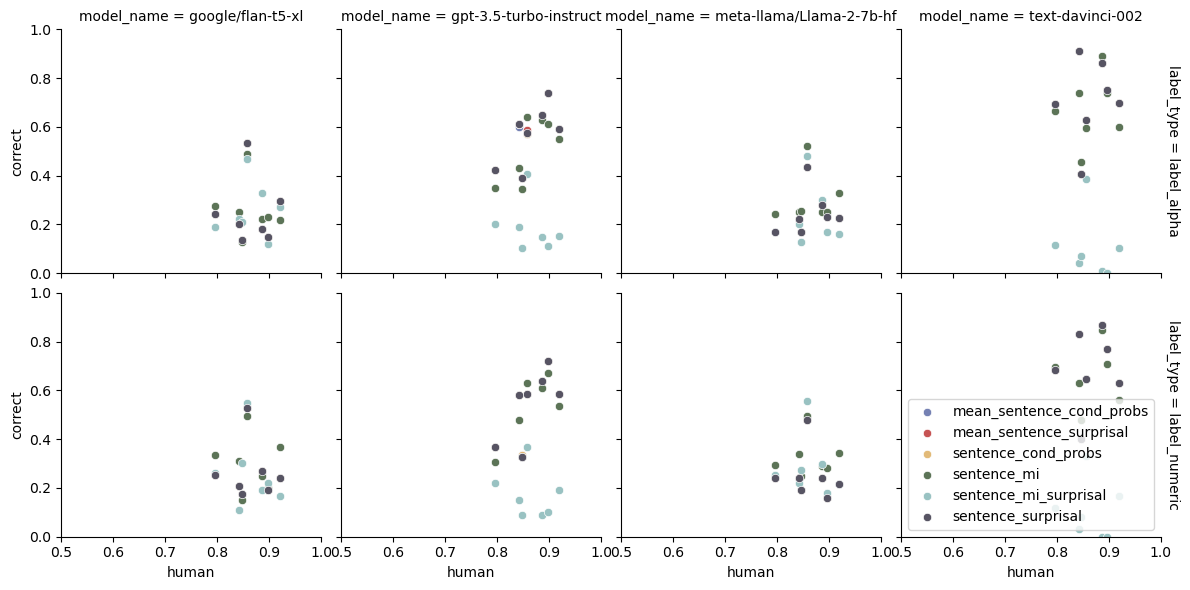

In [178]:
# plotting results by metric, by phenomenon, by model, by label type 
scores_binary_summary_wHuman
p1 = sns.FacetGrid(
    scores_binary_summary_wHuman, 
    col="model_name", 
    hue="metric_formula", 
    row="label_type",
    margin_titles=True,
)
p1.map_dataframe(sns.scatterplot, "human", "correct")
# sns.scatterplot(data=scores_binary_summary_wHuman, x="human", y="target", hue="phenomenon", style="metric_formula")
plt.xlim(0.5, 1)
plt.ylim(0, 1)
plt.legend()

In [179]:
scores_binary_summary_wHuman

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,correct,human
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.535000,0.856684
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.530000,0.856684
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.200000,0.841979
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.210000,0.841979
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.136000,0.846845
...,...,...,...,...,...,...,...,...
331,text-davinci-002,sentence_surprisal,irony,label_numeric,2.0,13.0,0.632000,0.919465
332,text-davinci-002,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.694737,0.795856
333,text-davinci-002,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.684211,0.795856
334,text-davinci-002,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.750000,0.896791


## Analyse the binarized argmaxed data 

In [27]:
# find best seed and best set of labels
# output the cleaned file
# plot detailed results (also by-category distribution breakdown)

In [180]:
# check if any seed is much better
label_scores_bySeed = label_scores.groupby(["model_name", "metric_formula", "seed"]).mean("correct").reset_index()

In [181]:
label_scores_bySeed_wide = label_scores_bySeed.pivot_table(
    columns=["seed"],
    values="correct",
    index=["model_name", "metric_formula", "item_id"]
).reset_index()
label_scores_bySeed_wide

seed,model_name,metric_formula,item_id,0,1,2,3,4
0,google/flan-t5-xl,mean_sentence_cond_probs,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899
1,google/flan-t5-xl,mean_sentence_surprisal,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899
2,google/flan-t5-xl,sentence_cond_probs,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899
3,google/flan-t5-xl,sentence_mi,13.550296,0.307692,0.272189,0.301775,0.328402,0.295858
4,google/flan-t5-xl,sentence_mi_surprisal,13.550296,0.304734,0.286982,0.322485,0.260355,0.260355
5,google/flan-t5-xl,sentence_surprisal,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899
6,gpt-3.5-turbo-instruct,mean_sentence_cond_probs,13.550296,0.544379,0.573964,0.538462,0.547337,0.568047
7,gpt-3.5-turbo-instruct,mean_sentence_surprisal,13.550296,0.550296,0.571006,0.541420,0.550296,0.568047
8,gpt-3.5-turbo-instruct,sentence_cond_probs,13.550296,0.547337,0.573964,0.541420,0.547337,0.565089
9,gpt-3.5-turbo-instruct,sentence_mi,13.550296,0.526627,0.500000,0.529586,0.497041,0.547337


In [182]:
def compute_diffs(r):
    cols = [0, 1, 2, 3, 4]
    vals = [r[o] for o in cols]
    return max(vals) - min(vals)

def max_col(r):
    cols = [0, 1, 2, 3, 4]
    vals = [r[o] for o in cols]
    return cols[vals.index(max(vals))]

In [183]:
label_scores_bySeed_wide["diff"] = label_scores_bySeed_wide.apply(lambda r: compute_diffs(r), axis = 1)
label_scores_bySeed_wide["max_seed"] = label_scores_bySeed_wide.apply(lambda r: max_col(r), axis = 1)

label_scores_bySeed_wide

seed,model_name,metric_formula,item_id,0,1,2,3,4,diff,max_seed
0,google/flan-t5-xl,mean_sentence_cond_probs,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899,0.056213,3
1,google/flan-t5-xl,mean_sentence_surprisal,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899,0.056213,3
2,google/flan-t5-xl,sentence_cond_probs,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899,0.056213,3
3,google/flan-t5-xl,sentence_mi,13.550296,0.307692,0.272189,0.301775,0.328402,0.295858,0.056213,3
4,google/flan-t5-xl,sentence_mi_surprisal,13.550296,0.304734,0.286982,0.322485,0.260355,0.260355,0.062130,2
5,google/flan-t5-xl,sentence_surprisal,13.550296,0.284024,0.263314,0.278107,0.319527,0.292899,0.056213,3
6,gpt-3.5-turbo-instruct,mean_sentence_cond_probs,13.550296,0.544379,0.573964,0.538462,0.547337,0.568047,0.035503,1
7,gpt-3.5-turbo-instruct,mean_sentence_surprisal,13.550296,0.550296,0.571006,0.541420,0.550296,0.568047,0.029586,1
8,gpt-3.5-turbo-instruct,sentence_cond_probs,13.550296,0.547337,0.573964,0.541420,0.547337,0.565089,0.032544,1
9,gpt-3.5-turbo-instruct,sentence_mi,13.550296,0.526627,0.500000,0.529586,0.497041,0.547337,0.050296,4


In [227]:
label_scores_bySeed_wide["max_seed"].value_counts()
# mean accuracy by seed
label_scores_bySeed.groupby(["seed"]).mean("correct")
# seed 3 has highest accuracy

shuffled_option_names,item_id,correct
seed,,
0,13.550296,0.411612
1,13.550296,0.409024
2,13.550296,0.409887
3,13.550296,0.418762
4,13.550296,0.412352


In [185]:
# check alphabetic vs numeric labels
label_scores_byLabel = label_scores.groupby(["model_name", "metric_formula", "label_type"]).mean("correct").reset_index()

In [51]:
label_scores_byLabel_wide = label_scores_byLabel.pivot_table(
    columns=["label_type"],
    values="correct",
    index=["model_name", "metric_formula", "item_id"]
).reset_index()
label_scores_byLabel_wide["diff"] = abs(label_scores_byLabel_wide["label_alpha"] - label_scores_byLabel_wide["label_numeric"])

In [186]:
label_scores_byLabel_wide["diff"].sort_values()

9     0.001183
4     0.008284
17    0.010651
14    0.010651
13    0.010651
12    0.010651
0     0.014201
5     0.014201
2     0.014201
1     0.014201
10    0.015385
8     0.017751
15    0.020118
7     0.021302
6     0.021302
11    0.022485
3     0.041420
16    0.060355
Name: diff, dtype: float64

In [229]:
# mean accuracy by label type
label_scores_byLabel.groupby(["label_type"]).mean("correct") 
# label numeric has slightly higher accuracy

shuffled_option_names,seed,item_id,correct
label_type,,,
label_alpha,2.0,13.550296,0.411045
label_numeric,2.0,13.550296,0.413609


The most variation of accuracy by metric induced by seeds is 0.1 and it was not deemed significant for selecting a particular seed. Similarly, there is no difference by label type. 

**But based on average accuracy by label type, the numeric labels are chosen. Similarly, seed 3 is chosen. **

In [187]:
label_scores

shuffled_option_names,metric_formula,model_name,seed,item_id,phenomenon,metric,label_type,chosen_option,correct
0,mean_sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,competitor,0
1,mean_sentence_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,competitor,0
2,sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,competitor,0
3,sentence_mi,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,competitor,0
4,sentence_mi_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1
...,...,...,...,...,...,...,...,...,...
4795,mean_sentence_surprisal,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1
4796,sentence_cond_probs,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1
4797,sentence_mi,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1
4798,sentence_mi_surprisal,text-davinci-002,4,20,metaphor,label_score,label_numeric,distractor_literal,0


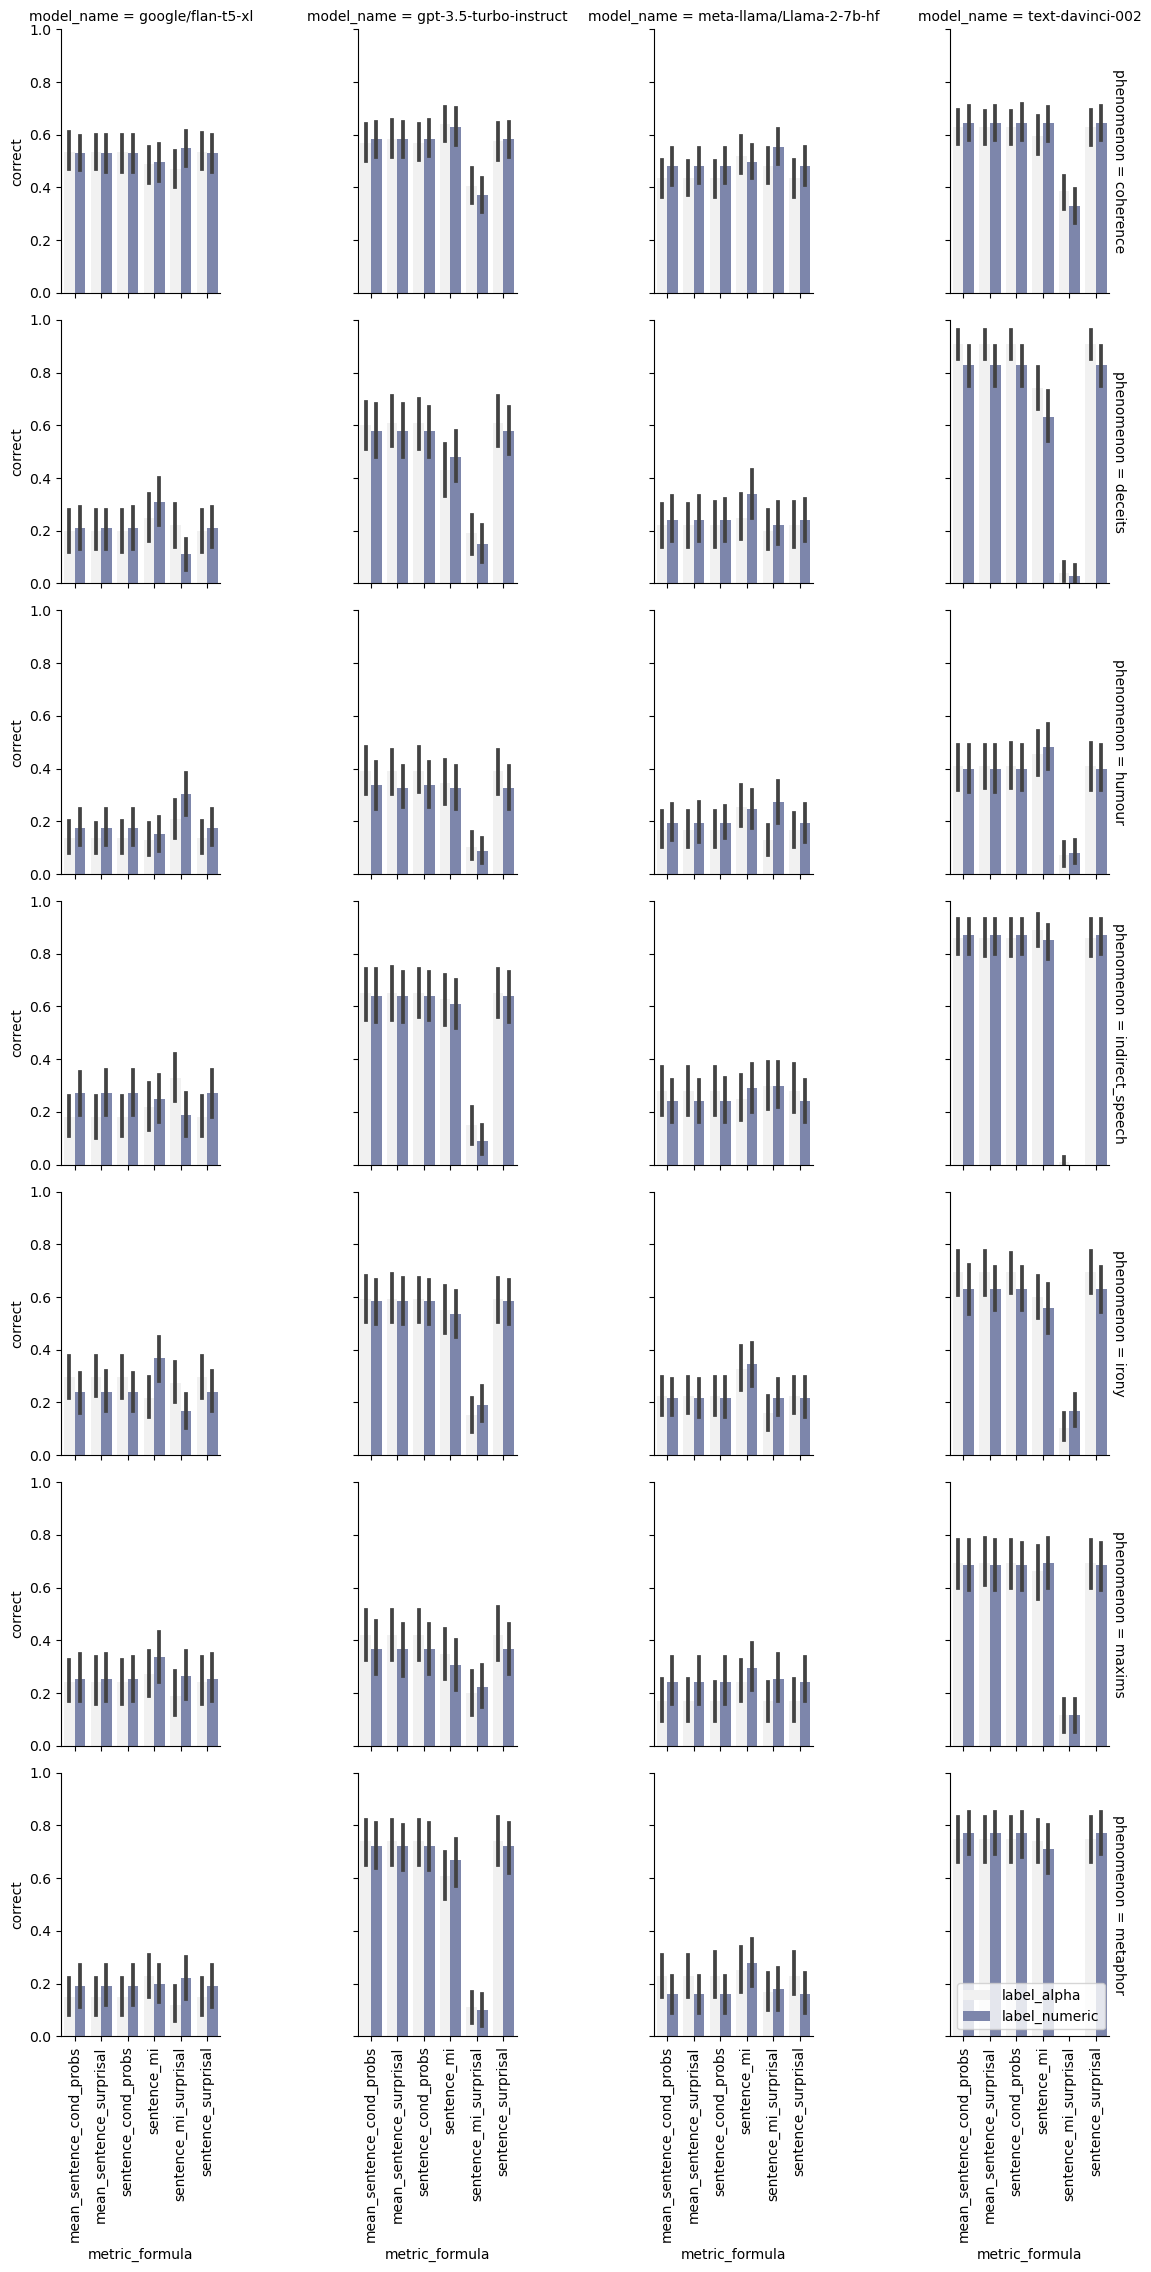

In [189]:
# plot accuracy (y axis) by phenomenon (rows) by model (cols) by label type (color) by metric (x axis) 
p_argmax = sns.FacetGrid(
    label_scores, 
    col = "model_name", 
    row="phenomenon",
    margin_titles=True,
)
p_argmax.map_dataframe(sns.barplot, x="metric_formula", y = "correct", hue = "label_type")
axes = p_argmax.axes.flatten()
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend()

In [190]:
label_scores_wide = label_scores.pivot_table(
    columns=["metric_formula"],
    values="correct",
    index=["model_name", "seed", "item_id", "phenomenon", "metric", "label_type"]
).reset_index()

In [192]:
label_scores
label_scores_out_long =label_scores[["metric_formula", "model_name", "item_id", "phenomenon", "metric", "correct"]]
label_scores_out_long = label_scores_out_long.rename(columns={"correct": "dependent_variable"})
# label_scores_out_long.to_csv("processed_data/label_scores_argmax_long.csv", index=False)

In [193]:
label_scores_out_wide = label_scores_wide[["model_name", "item_id", "phenomenon", "metric", "sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal" ]]
# label_scores_out_wide.to_csv("processed_data/label_scores_argmax_wide.csv", index=False)

In [195]:
df_human_all_forErrBars = pd.concat([df_human_all] * 4)
df_human_all_forErrBars["metric_formula"] = ["human"] * len(df_human_all) * 4  
df_human_all_forErrBars["model_name"] = ["google/flan-t5-xl"] * len(df_human_all) + ["gpt-3.5-turbo-instruct"] * len(df_human_all) + ["text-davinci-002"] * len(df_human_all) + ["meta-llama/Llama-2-7b-hf"] * len(df_human_all)

In [196]:
df_human_all_forErrBars

,Unnamed: 0,pKey,itemNum,Correct,Task,OptionChosen,phenomenon,metric_formula,model_name
0,1,100,27,0,CIV,Coherent,coherence,human,google/flan-t5-xl
1,2,100,21,1,CIV,Incoherent,coherence,human,google/flan-t5-xl
2,3,100,2,1,CIV,Coherent,coherence,human,google/flan-t5-xl
3,4,100,40,0,CIV,Coherent,coherence,human,google/flan-t5-xl
4,5,100,35,0,CIV,Coherent,coherence,human,google/flan-t5-xl
...,...,...,...,...,...,...,...,...,...
7475,7476,99,13,0,MV,Answer1,maxims,human,meta-llama/Llama-2-7b-hf
7476,7477,99,9,0,MV,Answer3,maxims,human,meta-llama/Llama-2-7b-hf
7477,7478,99,20,1,MV,Answer2,maxims,human,meta-llama/Llama-2-7b-hf
7478,7479,99,10,0,MV,Answer1,maxims,human,meta-llama/Llama-2-7b-hf


In [197]:
# add human data to label_scores
label_scores_wHuman = label_scores[["metric_formula", "model_name", "phenomenon", "correct"]]
df_human_all_forErrBars = df_human_all_forErrBars.rename(columns={"Correct": "correct"})[["metric_formula", "model_name", "phenomenon", "correct"]]
label_scores_wHuman = pd.concat([label_scores_wHuman, df_human_all_forErrBars])
label_scores_wHuman

,metric_formula,model_name,phenomenon,correct
0,mean_sentence_cond_probs,google/flan-t5-xl,coherence,0
1,mean_sentence_surprisal,google/flan-t5-xl,coherence,0
2,sentence_cond_probs,google/flan-t5-xl,coherence,0
3,sentence_mi,google/flan-t5-xl,coherence,0
4,sentence_mi_surprisal,google/flan-t5-xl,coherence,1
...,...,...,...,...
7475,human,meta-llama/Llama-2-7b-hf,maxims,0
7476,human,meta-llama/Llama-2-7b-hf,maxims,0
7477,human,meta-llama/Llama-2-7b-hf,maxims,1
7478,human,meta-llama/Llama-2-7b-hf,maxims,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


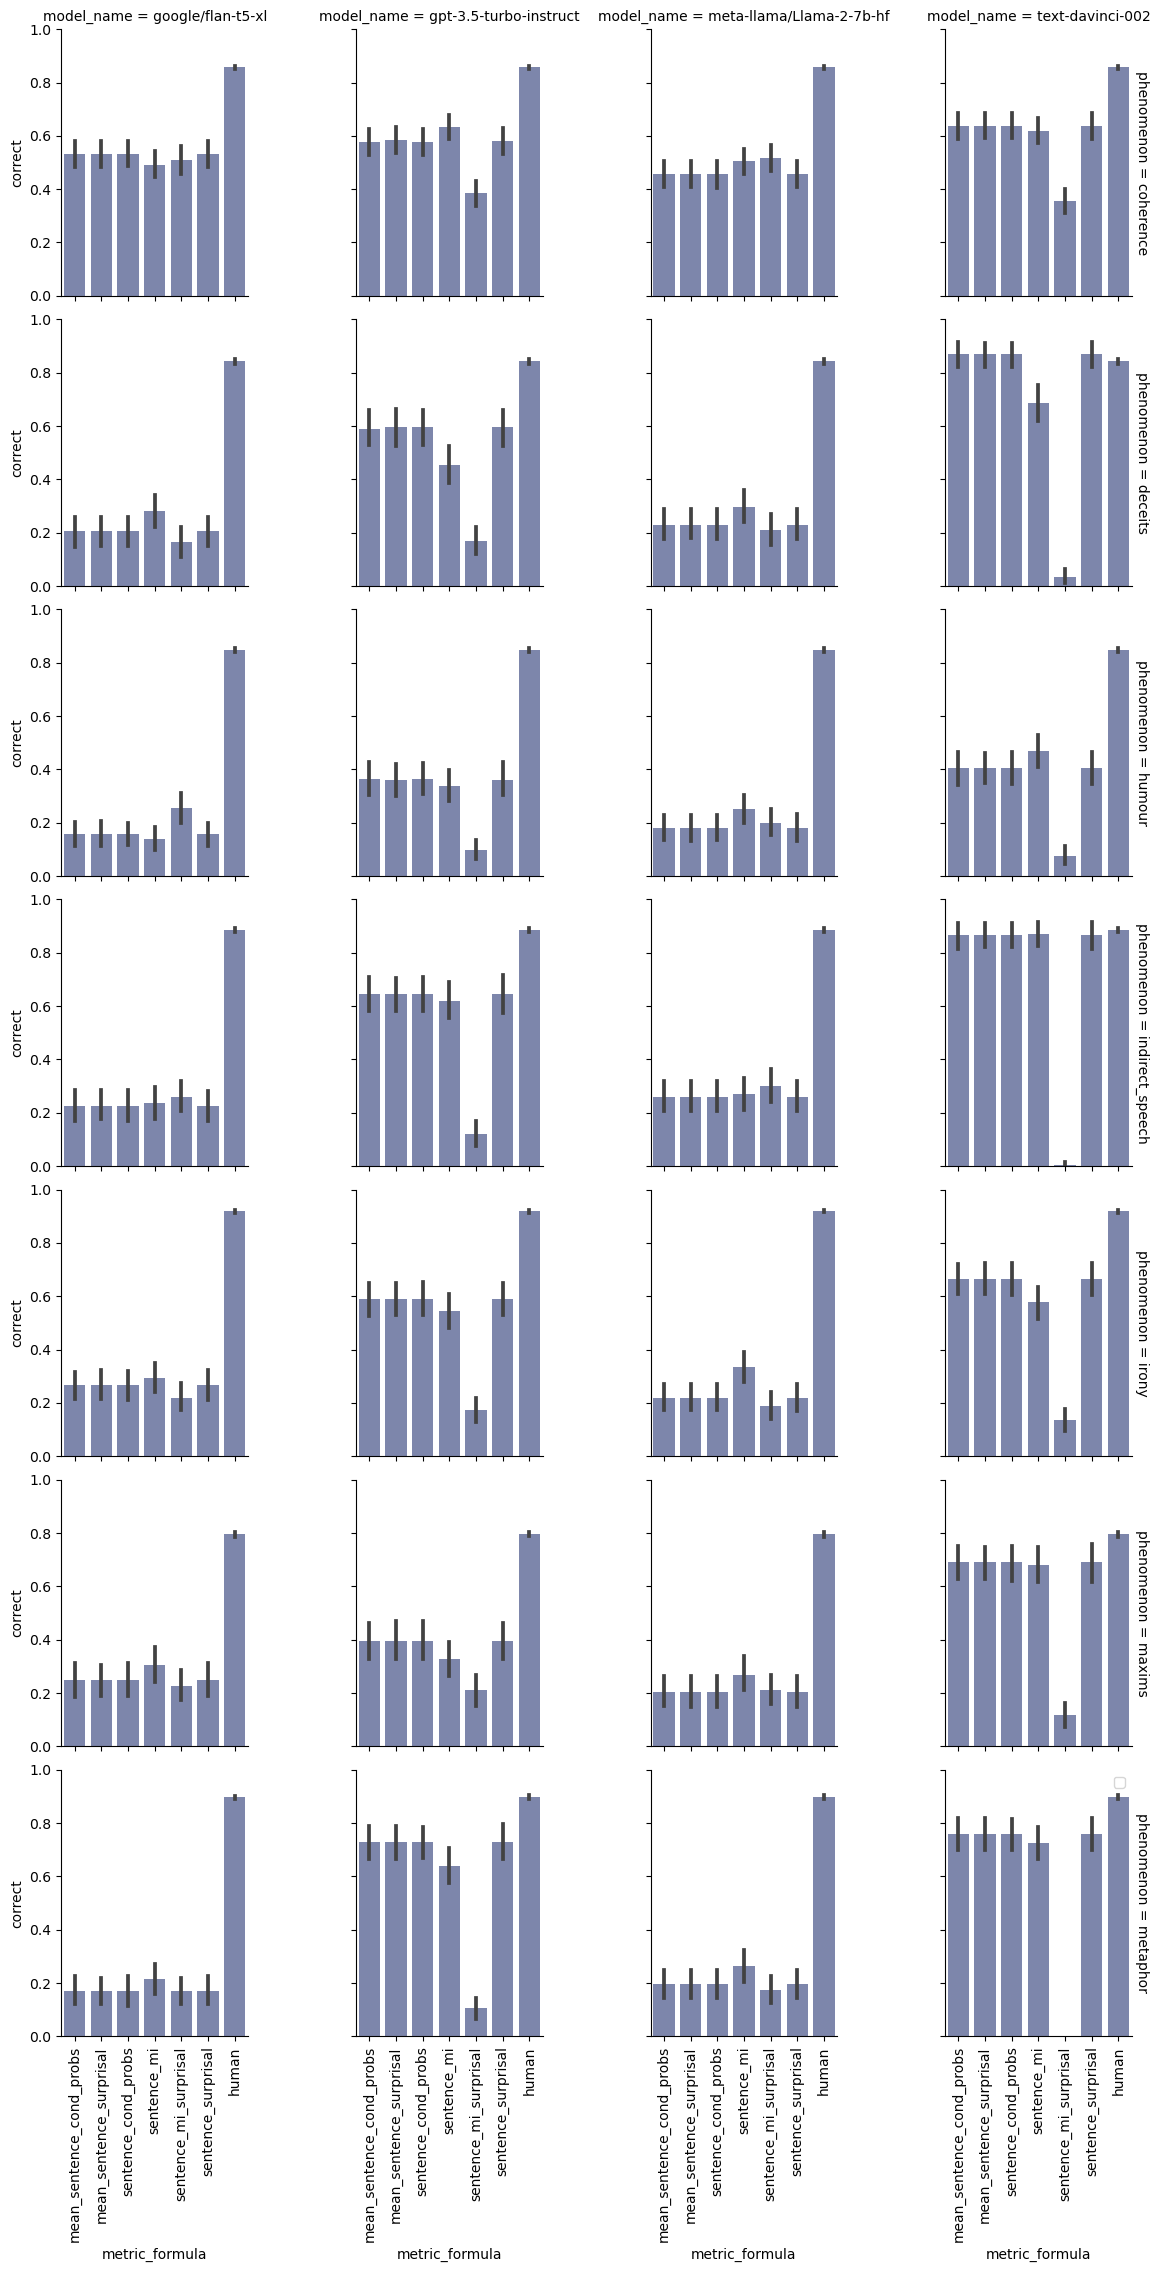

In [198]:
# plot accuracy across label types, by phenomenon, together with human data
p_argmax_summary = sns.FacetGrid(
    label_scores_wHuman, 
    col = "model_name", 
    row="phenomenon",
    margin_titles=True,
)
p_argmax_summary.map_dataframe(sns.barplot, x="metric_formula", y = "correct")
axes = p_argmax_summary.axes.flatten()
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend()

In [225]:
tdv2 = label_scores_wHuman[label_scores_wHuman["model_name"] == "text-davinci-002"]
tdv2_metaphor = tdv2[tdv2["phenomenon"] == "metaphor"]
# any([o == 1 for o in tdv2_metaphor[tdv2_metaphor["metric_formula"] == "sentence_mi_surprisal"]["correct"]])

False

In [230]:
# for the grand plot in the paper, we want to know which metric results in highest accuracy
# both across and by model
# across phenomena
label_scores.groupby(["model_name", "metric_formula"]).mean("correct")

shuffled_option_names                              seed    item_id   correct
model_name               metric_formula                                     
google/flan-t5-xl        mean_sentence_cond_probs   2.0  13.550296  0.287574
                         mean_sentence_surprisal    2.0  13.550296  0.287574
                         sentence_cond_probs        2.0  13.550296  0.287574
                         sentence_mi                2.0  13.550296  0.301183
                         sentence_mi_surprisal      2.0  13.550296  0.286982
                         sentence_surprisal         2.0  13.550296  0.287574
gpt-3.5-turbo-instruct   mean_sentence_cond_probs   2.0  13.550296  0.554438
                         mean_sentence_surprisal    2.0  13.550296  0.556213
                         sentence_cond_probs        2.0  13.550296  0.555030
                         sentence_mi                2.0  13.550296  0.520118
                         sentence_mi_surprisal      2.0  13.550296  0.201775
                         sentence_surprisal         2.0  13.550296  0.555030
meta-llama/Llama-2-7b-hf mean_sentence_cond_probs   2.0  13.550296  0.271598
                         mean_sentence_surprisal    2.0  13.550296  0.271598
                         sentence_cond_probs        2.0  13.550296  0.271598
                         sentence_mi                2.0  13.550296  0.335503
                         sentence_mi_surprisal      2.0  13.550296  0.284615
                         sentence_surprisal         2.0  13.550296  0.271598
text-davinci-002         mean_sentence_cond_probs   2.0  13.550296  0.681657
                         mean_sentence_surprisal    2.0  13.550296  0.681657
                         sentence_cond_probs        2.0  13.550296  0.681657
                         sentence_mi                2.0  13.550296  0.647929
                         sentence_mi_surprisal      2.0  13.550296  0.133728
                         sentence_surprisal         2.0  13.550296  0.681657

Results by model:
* T5: sentence_mi
* LLama: sentence_mi
* gpt-3.5: mean sentence surprisal
* davinci-002: any of: sentence surprisal, sentence cond prob, mean_sentence_cond_probs, mean_sentence_surprisal

In [231]:
# across models: sentence_mi
label_scores.groupby(["metric_formula"]).mean("correct")

shuffled_option_names,seed,item_id,correct
metric_formula,,,
mean_sentence_cond_probs,2.0,13.550296,0.448817
mean_sentence_surprisal,2.0,13.550296,0.449260
sentence_cond_probs,2.0,13.550296,0.448964
sentence_mi,2.0,13.550296,0.451183
sentence_mi_surprisal,2.0,13.550296,0.226775
sentence_surprisal,2.0,13.550296,0.448964


In [233]:
# subset data to best configs, respectively
# long format first
label_scores_bestConfigs = label_scores[
    (label_scores["metric_formula"] == "sentence_mi") & 
    (label_scores["seed"] == 3) &
    (label_scores["label_type"] == "label_numeric")
]
label_scores_bestConfigs_out = label_scores_bestConfigs[["metric_formula", "model_name", "item_id", "phenomenon", "metric", "correct"]]
label_scores_bestConfigs_out = label_scores_bestConfigs_out.rename(columns={"correct": "dependent_variable"})
# label_scores_bestConfigs_out.to_csv("processed_data/label_scores_argmax_bestConfigs_long.csv", index=False)

In [239]:
# now summary of best config
label_scores_bestConfigs_out = label_scores_bestConfigs_out.rename(columns={"correct": "dependent_variable"})
label_scores_bestConfigs_out_summary = label_scores_bestConfigs_out.groupby(["model_name", "phenomenon", "metric_formula", "metric"]).mean("correct").reset_index()
label_scores_bestConfigs_out_summary = label_scores_bestConfigs_out_summary[["model_name", "metric_formula", "phenomenon", "metric", "dependent_variable"]]
# label_scores_bestConfigs_out_summary.to_csv("processed_data/label_scores_accuracy_bestConfigs_summary.csv", index=False)

<AxesSubplot:xlabel='phenomenon', ylabel='correct'>

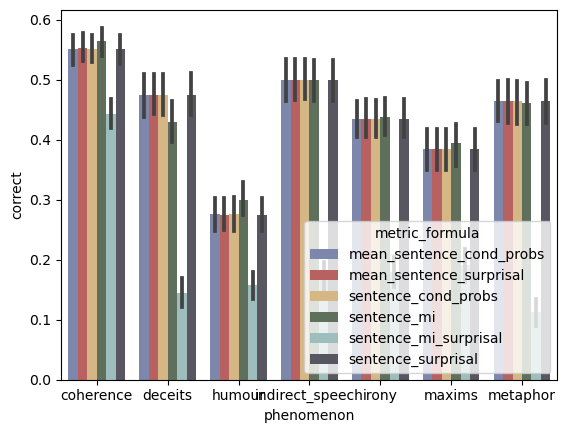

In [199]:
# across models
sns.barplot(label_scores, x="phenomenon", y = "correct", hue="metric_formula")


In [200]:
# plot distributions of chosen options
label_scores_byOption_summary = label_scores.groupby(
    ['model_name', 'phenomenon']
)["chosen_option"].value_counts(normalize=True).unstack().fillna(0).reset_index()

In [201]:
label_scores_byOption_summary

chosen_option,model_name,phenomenon,associative_nonsequitur,competitor,distractor_associate,distractor_associative,distractor_lexical_overlap,distractor_literal,distractor_nonsequitur,distractor_nonsequitut,distractor_plausibleliteral,funny_nonsequitur,incorrect_associate,incorrect_lexical_overlap,incorrect_literal,incorrect_nonliteral,incorrect_social_convention,incorrect_straightforward,neutral_nonsequitur,target
0,google/flan-t5-xl,coherence,0.000000,0.477917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.522083
1,google/flan-t5-xl,deceits,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322500,0.217500,0.000000,0.249167,0.000000,0.000000,0.210833
2,google/flan-t5-xl,humour,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223333,0.000000,0.000000,0.000000,0.000000,0.000000,0.178667,0.208000,0.170000
3,google/flan-t5-xl,indirect_speech,0.000000,0.276667,0.000000,0.222500,0.268333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.232500
4,google/flan-t5-xl,irony,0.000000,0.273333,0.238667,0.000000,0.000000,0.000000,0.224000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264000
5,google/flan-t5-xl,maxims,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244737,0.000000,0.221053,0.280702,0.000000,0.000000,0.000000,0.253509
6,google/flan-t5-xl,metaphor,0.000000,0.255833,0.000000,0.000000,0.000000,0.190833,0.000000,0.191667,0.184167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.177500
7,gpt-3.5-turbo-instruct,coherence,0.000000,0.442917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557083
8,gpt-3.5-turbo-instruct,deceits,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084167,0.335833,0.000000,0.080000,0.000000,0.000000,0.500000
9,gpt-3.5-turbo-instruct,humour,0.062667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119333,0.000000,0.000000,0.000000,0.000000,0.000000,0.476000,0.028667,0.313333


In [207]:
df_human_all[df_human_all["phenomenon"] == "coherence"]["Correct"].mean()

0.8566844919786096

In [208]:
human_category_summary_avg_unique = human_category_summary_avg[["phenomenon", "value", "model_name", "shuffled_option_names"]].drop_duplicates()
human_category_summary_avg_unique = human_category_summary_avg_unique.rename(columns={"value": "proportion", "shuffled_option_names": "response_option"})
# TODO: manually add human coherence results
human_category_summary_avg_unique.loc[26] = {"phenomenon": "coherence", "proportion": 0.86, "model_name": "human", "response_option":"target"}
human_category_summary_avg_unique.loc[27] = {"phenomenon": "coherence", "proportion": 0.14, "model_name": "human", "response_option":"competitor"}

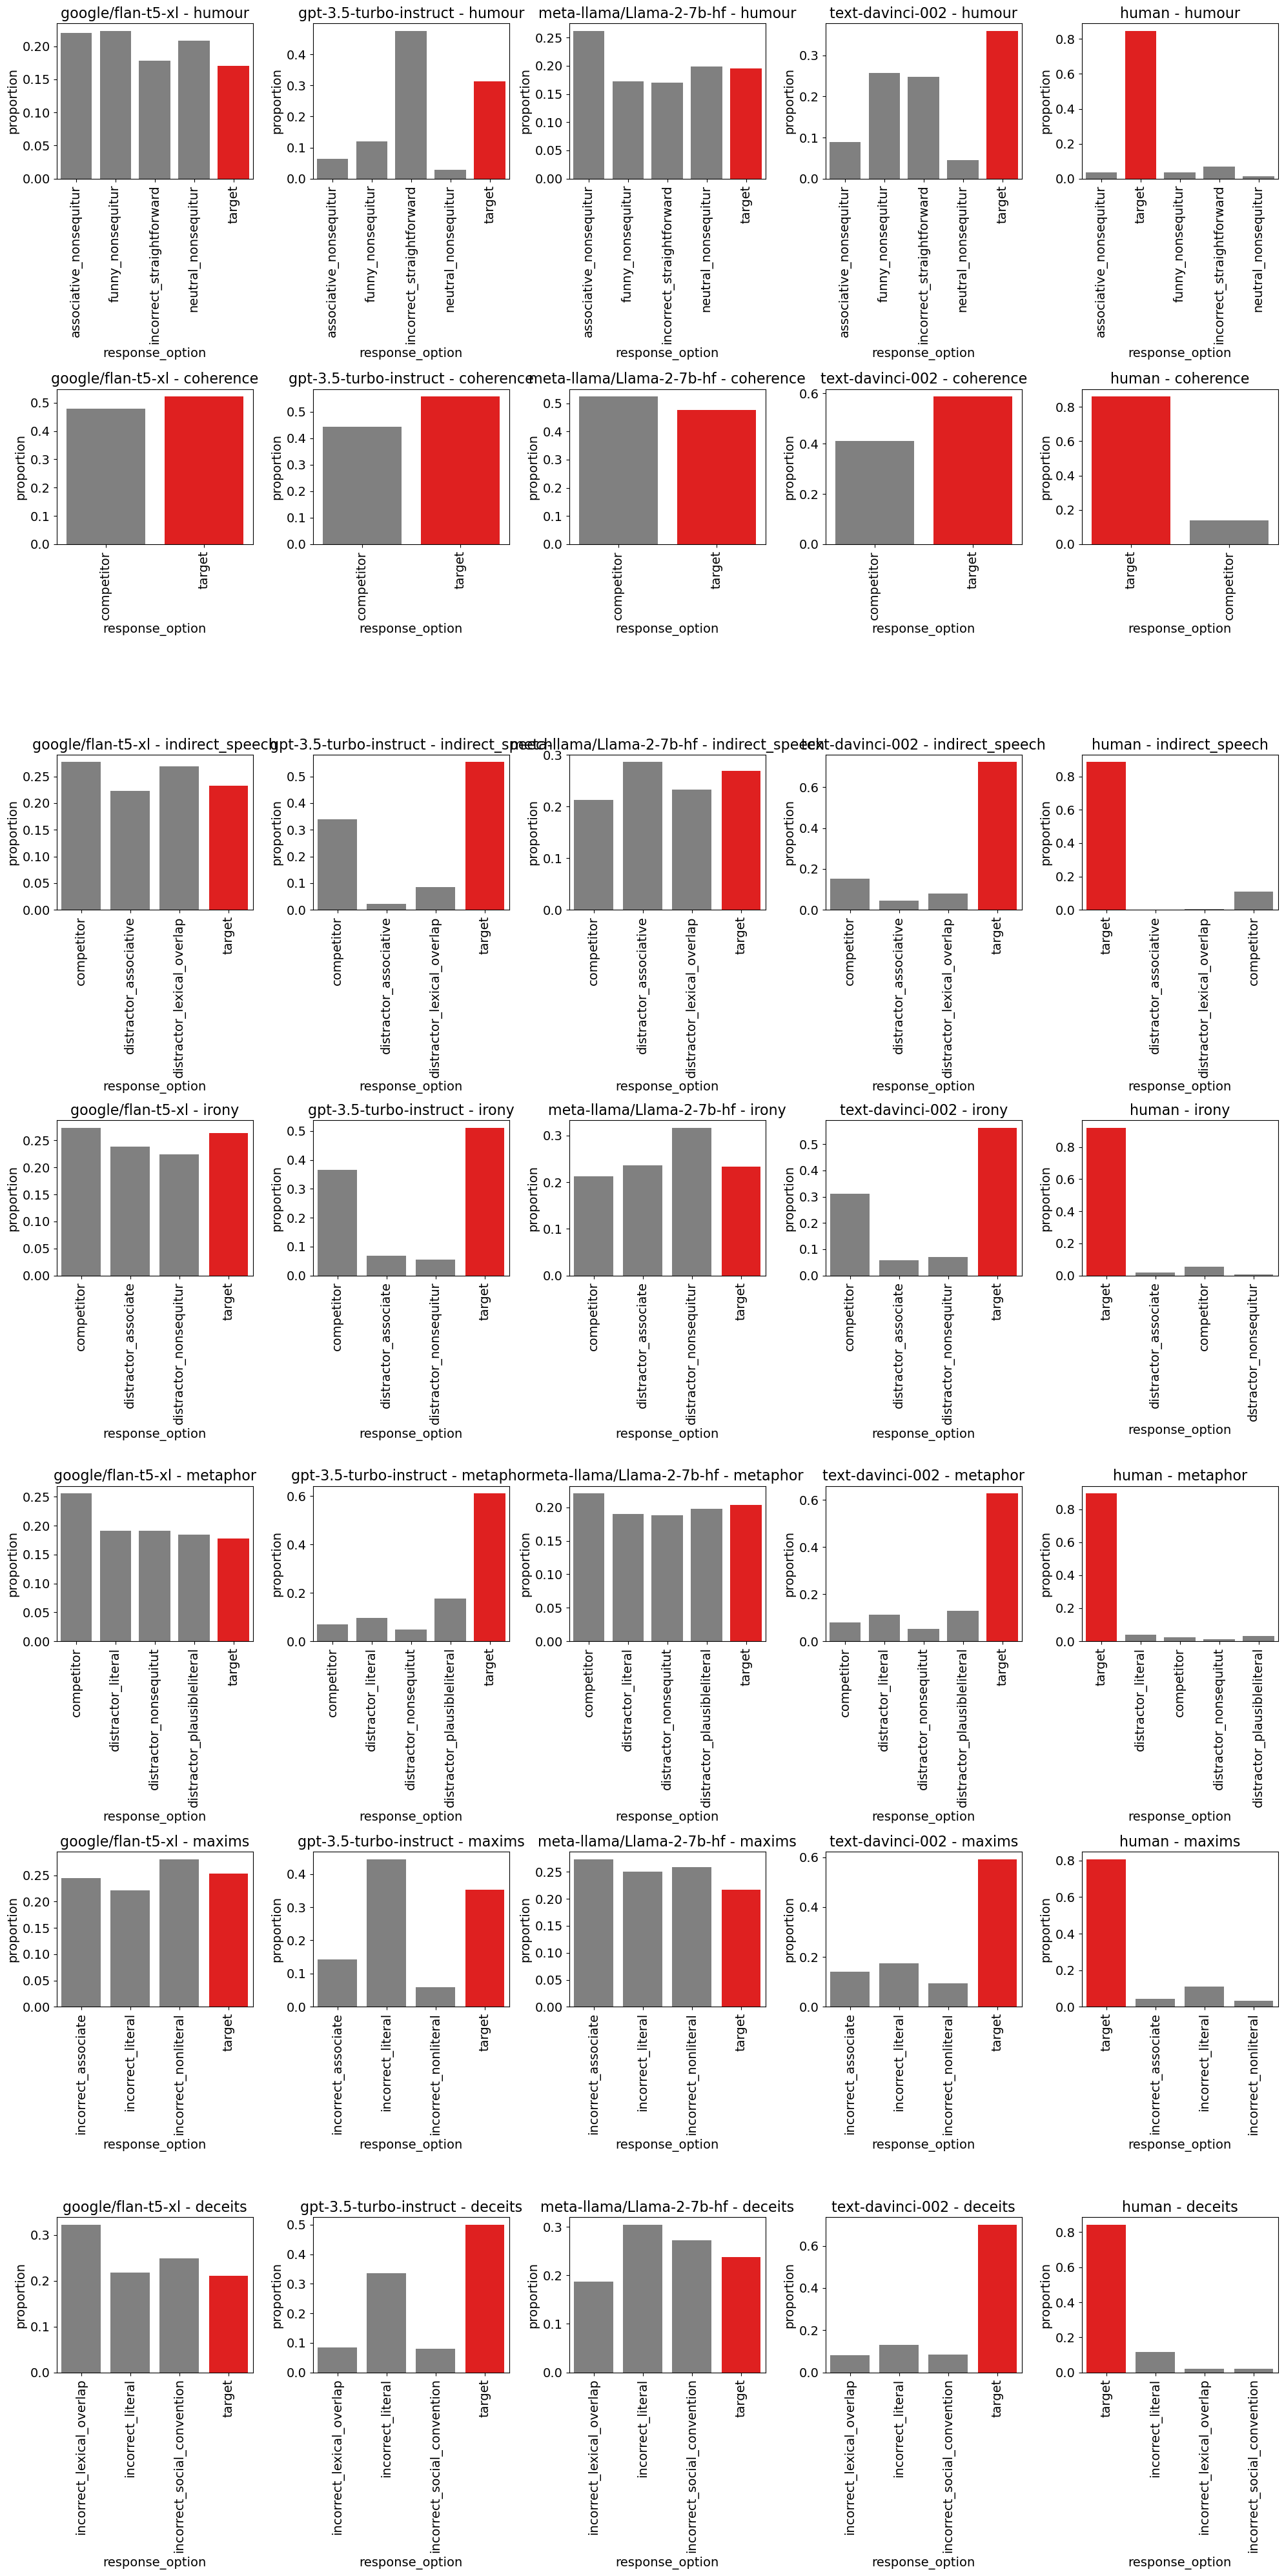

In [209]:
# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
label_scores_byOption_summary_long = label_scores_byOption_summary.melt(id_vars=['phenomenon', 'model_name'], 
                                                 value_vars=label_scores_byOption_summary.columns, 
                                                 var_name='response_option', 
                                                 value_name='proportion')

# Filter out rows where normalized_count is zero to only plot non-zero responses
label_scores_byOption_summary_long_nonZero = label_scores_byOption_summary_long[label_scores_byOption_summary_long['proportion'] > 0]

label_scores_byOption_summary_long_nonZero = pd.concat([label_scores_byOption_summary_long_nonZero, human_category_summary_avg_unique])

## Extract unique models and phenomena
unique_models = label_scores_byOption_summary_long_nonZero['model_name'].unique()
unique_phenomena = label_scores_byOption_summary_long_nonZero['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in label_scores_byOption_summary_long_nonZero['response_option'].unique()}

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=False)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset_data = label_scores_byOption_summary_long_nonZero[(label_scores_byOption_summary_long_nonZero['model_name'] == model) & 
                                           (label_scores_byOption_summary_long_nonZero['phenomenon'] == phenomenon)]
        sns.barplot(data=subset_data, x='response_option', y='proportion', ax=ax, palette=palette)
        ax.set_title(f"{model} - {phenomenon}")
        ax.tick_params(axis="x", rotation=90)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.tight_layout()
plt.show()

In [216]:
# create short summary
label_scores_summary_out = label_scores.groupby(["model_name", "metric_formula", "phenomenon", "metric"]).mean("correct").reset_index()

In [217]:
label_scores_summary_out = label_scores_summary_out[["model_name", "metric_formula", "phenomenon", "metric", "correct"]]

In [219]:
label_scores_summary_out = label_scores_summary_out.rename(columns={"correct":"dependent_variable"})

In [238]:
# label_scores_summary_out.to_csv("processed_data/label_scores_accuracy_summary.csv", index=False)